# Получение данных из БД с помощью естественного языка

In [ ]:
!pip install transformers
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+${CUDA}.html

In [ ]:
import tensorflow as tf
import numpy as np
import os
import pickle
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from string import punctuation
from transformers import AutoModelForTableQuestionAnswering, AutoTokenizer, pipeline
import pandas as pd

In [ ]:
data = pd.read_csv('order_management.csv', sep=';')
data

,c_id,c_name,c_address,c_phone,c_person
0,1,John Doe,123 Main St,555-1234,John
1,2,Jane Smith,456 Elm St,555-5678,Jane
2,3,Mike Johnson,789 Oak St,555-9101,Mike
3,4,Sarah Williams,101 Pine St,555-1213,Sarah
4,5,Chris Brown,202 Maple St,555-1415,Chris
5,6,Emily Davis,303 Cedar St,555-1617,Emily
6,7,Alex Robinson,404 Walnut St,555-1819,Alex
7,8,Olivia Martinez,505 Birch St,555-2021,Olivia
8,9,Daniel Garcia,606 Spruce St,555-2223,Daniel
9,10,Sophia Hernandez,707 Sycamore St,555-2425,Sophia


In [ ]:
data = data.astype(str)

In [ ]:
model = 'google/tapas-base-finetuned-wtq'
tapas_model = AutoModelForTableQuestionAnswering.from_pretrained(model)
tapas_tokenizer = AutoTokenizer.from_pretrained(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/490 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/262k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

In [ ]:
nlp = pipeline('table-question-answering', model=tapas_model, tokenizer=tapas_tokenizer)

def qa(query,data):
  print('>>>>>')
  print(query)
  result = nlp({'table': data,'query':query})
  answer = result['cells']
  print(answer)

In [ ]:
prediction = qa('What is the biggest user id?',data)

>>>>>
What is the biggest user id?
['10']


In [ ]:
prediction = qa('What is the full name of Davis?',data)

>>>>>
What is the full name of Davis?
['Emily Davis']


In [ ]:
prediction = qa('What Mike phone number?',data)

>>>>>
What Mike phone number?
['555-9101']


# Генерация изображения

In [ ]:
!pip install transformers diffusers translators

Введите фразу для генерации картинки: man


<ipython-input-22-120e971e0b5c>:64: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, self.unet.in_channels, dim//8, dim//8)) #Начальный случайный шум


  0%|          | 0/70 [00:00<?, ?it/s]

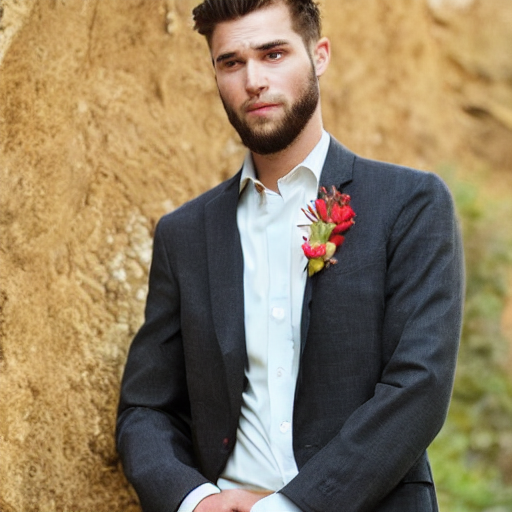

In [ ]:
import torch # Для работы с нейронными сетями
import logging # Для логирования
from tqdm.auto import tqdm # Полоска прогресса
from IPython.display import display # Для вывода изображения в .ipynb файле
import os # Для работы с папками
import translators as ts # Для перевода
# Библиотеки для работы с фотографиями
from PIL import Image
from torchvision import transforms as tfms
## Необходимые библиотеки для CLIP
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

class ImageGenerator():
  def __init__(self) -> None:
    # Отключение предупреждений при логировании
    logging.disable(logging.WARNING)
    # Определение токенайзера и кодировщика
    self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
    self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
    # Определение VAE
    self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
    # Создание необходимых объектов для последовательного зашумления изображения и установка шагов семплинга
    self.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    self.scheduler.set_timesteps(50)
    ## Определение U-Net модели
    self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

  '''Функция для загрузки изображения из определенного пути'''
  def load_image(self, p) -> Image: return Image.open(p).convert('RGB').resize((512,512))

  '''Функция для преобразования изображения в латенты'''
  def pil_to_latents(self, image):
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16)
    init_latent_dist = self.vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

  '''Функция для преобразования латентов в изображение'''
  def latents_to_pil(self, latents):
    latents = (1 / 0.18215) * latents
    with torch.no_grad(): image = self.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

  '''Функция, принимающая текстовую фразу и преобразующая ее в эмбеддинги'''
  def text_enc(self, prompts, maxlen=None):
    if maxlen is None: maxlen = self.tokenizer.model_max_length
    inp = self.tokenizer(prompts, padding="max_length",
    max_length=maxlen, truncation=True, return_tensors="pt")
    return self.text_encoder(inp.input_ids.to("cuda"))[0].half()

  """Диффузионный процесс преобразования текстовой фразы в изображение"""
  def prompt_2_img(self, prompts, g=7.5, seed=None, steps=70, dim=512, save_int=False):
    bs = len(prompts) #Определение размера блока
    text = self.text_enc(prompts) #Преобразование текстовой фразы в эмбеддинги
    #Добавление безусловной фразы, помогает в процессе генерации
    uncond = self.text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed) # Установка сида
    latents = torch.randn((bs, self.unet.in_channels, dim//8, dim//8)) #Начальный случайный шум
    self.scheduler.set_timesteps(steps) #Установка количества шагов семплинга
    latents = latents.to("cuda").half() * self.scheduler.init_noise_sigma #Добавление шума в латенты
    # Для каждого шага
    for i,ts in enumerate(tqdm(self.scheduler.timesteps)):
      # Необходимо масштабировать латентные значения i/p, чтобы они соответствовали дисперсии
      inp = self.scheduler.scale_model_input(torch.cat([latents] * 2), ts)
      # Прогнозирование остаточного шума с использованием U-Net
      with torch.no_grad(): u,t = self.unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
      pred = u + g*(t-u) #Выполнение прогноза
      latents = self.scheduler.step(pred, ts, latents).prev_sample #Добавление условий в латенты
      # Сохранение изображений на каждом шаге
      if save_int:
        if not os.path.exists('./steps'):
          os.mkdir('./steps')
        self.latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
    return self.latents_to_pil(latents) # Возвращаем латенты, которые представляют изображение размером 3x512x512

if __name__ == "__main__":
  engPrompt = input("Введите фразу для генерации картинки: ")
  # engPrompt = ts.translate_text(prompt, "deepl", to_language="en")
  ig = ImageGenerator()
  images = ig.prompt_2_img([engPrompt], save_int=False)
  for img in images: display(img)